In [ ]:
!pip install PyTDC
!pip install lifelines
!pip install rdkit-pypi

In [ ]:
import rdkit

In [ ]:
from tdc.single_pred import Tox
data = Tox(name = 'LD50_Zhu')
split = data.get_split()

Downloading...
100%|██████████| 707k/707k [00:00<00:00, 2.78MiB/s]
Loading...
Done!


In [ ]:
split.keys()

dict_keys(['train', 'valid', 'test'])

In [ ]:
split['train']

In [ ]:
split['valid']

In [ ]:
split['test']

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [ ]:
import numpy as np

In [ ]:
def smiles2morgan(s, radius = 2, nBits = 1024): # smiles-->morgan 
    try:
        mol = Chem.MolFromSmiles(s)
        features_vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        features = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(features_vec, features)
    except: # 예외 처리
        print('rdkit not found this smiles for morgan: ' + s + ' convert to all 0 features')
        features = np.zeros((nBits, ))
    return features

In [ ]:
for mode in ['train', 'valid', 'test']:  
  split[mode]['embedding'] = split[mode]['Drug'].apply(smiles2morgan) # 기존 칼럼

In [ ]:
from torch import nn 

In [ ]:
import torch.nn.functional as F

In [ ]:
from torch.utils import data

In [ ]:
split["test"]

,Drug_ID,Drug,Y,embedding
0,"Ether, alpha-(bromomethyl)-p-cyclopentylbenzyl...",CCCCOC(CBr)c1ccc(C2CCCC2)cc1,3.114,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Benzene, 1,4-dinitroso-",O=Nc1ccc(N=O)cc1,2.125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Succinic acid, mercapto-, diethyl ester, S-est...",CCOC(=O)CC(SP(=O)(OC)SC)C(=O)OCC,3.466,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"Phosphorodithioic acid, O,S,S-triethyl ester",CCOP(=O)(SCC)SCC,3.185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"Phenol, 2-octyl- (9CI)",CCCCCCCCc1ccccc1O,1.867,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
1472,"1H-1,2,4-Triazole, 1-((2-(2,4-dichlorophenyl)-...",CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,2.353,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1473,"Phosphorothioic acid, O-(3-chloro-4-nitropheny...",CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])c(Cl)c1,3.814,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1474,"Dibenz(b,f)oxepin-2-acetic acid, 10,11-dihydro...",Cc1ccc2c(c1)CC(=O)c1cc(CC(=O)O)ccc1O2,2.937,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1475,"Phosphorothioic acid, O,O-dimethyl S-(2-(ethyl...",CCS(=O)(=O)CCSP(=O)(OC)OC,3.908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
split["test"]['embedding'][0].shape

(1024,)

In [ ]:
#-------------------------데이터 준비과정

In [ ]:
# Dataset 만들기

In [ ]:
class data_process_loader(data.Dataset):
  def __init__(self, df):
    'Initialization'
    self.df = df

  def __len__(self):
    'Denotes the total number of samples'
    return self.df.shape[0]
  def __getitem__(self, index): 
    v_d = self.df.iloc[index]['embedding'] 
    y = self.df.iloc[index]['Y'] 

    return v_d, y


In [ ]:
train_dataset = data_process_loader(split["train"])
valid_dataset = data_process_loader(split["valid"])
test_dataset = data_process_loader(split["test"])

In [ ]:
for emd, y in train_dataset:
  print(emd)
  print(y)

In [ ]:
params = {'batch_size': 64,
      'shuffle': True,
      'num_workers': 1, #데이터가 많을때 높은 수
      'drop_last': False}  #나머지 버리기

In [ ]:
training_generator = data.DataLoader(train_dataset, **params)
valid_generator = data.DataLoader(valid_dataset, **params)
test_generator = data.DataLoader(test_dataset, **params)

In [ ]:
for v_d, y in training_generator:
  print(v_d)
  print(v_d.shape)
  print(y)
  print(y.shape)
  break

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
torch.Size([64, 1024])
tensor([1.7060, 1.7410, 1.8840, 1.6080, 5.4790, 1.3900, 1.6990, 1.8140, 2.1240,
        2.0920, 1.7220, 1.5220, 2.7390, 2.6190, 3.0590, 2.2450, 0.7570, 2.2240,
        3.5960, 1.1430, 1.8410, 2.5960, 2.4720, 1.5410, 4.8630, 1.2480, 1.6860,
        3.0320, 2.7250, 1.8540, 2.0470, 2.1030, 2.3300, 1.4500, 3.4970, 3.8490,
        0.9700, 2.9040, 3.7820, 2.5890, 1.6590, 2.4850, 1.7510, 1.6270, 3.1130,
        1.6630, 5.4040, 1.5870, 2.3300, 1.5920, 3.3590, 2.9200, 1.2240, 1.6970,
        2.1630, 4.4720, 3.7400, 2.0890, 1.9930, 2.0550, 1.9280, 2.3600, 1.6380,
        3.2230], dtype=torch.float64)
torch.Size([64])


In [ ]:
#---------------데이터 준비 끝

In [ ]:
# 모델 만들기

In [ ]:
import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MLP(nn.Sequential):
	def __init__(self, input_dim, output_dim, hidden_dims_lst):
		'''
			input_dim (int)
			output_dim (int)
			hidden_dims_lst (list, each element is a integer, indicating the hidden size)
		'''
		super(MLP, self).__init__()
		layer_size = len(hidden_dims_lst) + 1
		dims = [input_dim] + hidden_dims_lst + [output_dim]

		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v):
		# predict
		v = v.float().to(device)
		for i, l in enumerate(self.predictor):
			v = F.relu(l(v))
		return v  


In [ ]:
class Classifier(nn.Sequential):
	def __init__(self, model_drug, hidden_dim_drug, cls_hidden_dims):
		super(Classifier, self).__init__()
		self.input_dim_drug = hidden_dim_drug

		self.model_drug = model_drug

		self.dropout = nn.Dropout(0.1)

		self.hidden_dims = cls_hidden_dims
		layer_size = len(self.hidden_dims) + 1
		dims = [self.input_dim_drug] + self.hidden_dims + [1]
		
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v_D):
		# each encoding
		v_f = self.model_drug(v_D)
		# concatenate and classify
		for i, l in enumerate(self.predictor):
			if i==(len(self.predictor)-1):
				v_f = l(v_f)
			else:
				v_f = F.relu(self.dropout(l(v_f)))
		return v_f 

In [ ]:
input_dim_drug = 1024
hidden_dim_drug = 256
cls_hidden_dims = [1024, 1024, 512]
mlp_hidden_dims_drug = [1024, 256, 64]

In [ ]:
model_drug = MLP(1024, hidden_dim_drug, mlp_hidden_dims_drug)

In [ ]:
model_drug

MLP(
  (predictor): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=256, bias=True)
  )
)

In [ ]:
model = Classifier(model_drug, hidden_dim_drug, cls_hidden_dims)

In [ ]:
model

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
learning_rate = 0.0001
decay = 0.00001

In [ ]:
train_epoch = 50

In [ ]:
loss_history = []

In [ ]:
model = model.to(device)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)

In [ ]:
max_MSE = 10000

In [ ]:
import copy # validation best인 놈들 check

In [ ]:
model_max = copy.deepcopy(model)

In [ ]:
valid_metric_record = []
valid_metric_header = ["# epoch"] 

In [ ]:
valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])

In [ ]:
from prettytable import PrettyTable

In [ ]:
table = PrettyTable(valid_metric_header)

In [ ]:
float2str = lambda x:"%0.4f"%x

In [ ]:
print('--- Go for Training ---')

--- Go for Training ---


In [ ]:
from time import time

In [ ]:
t_start = time() 

In [ ]:
loss_fct = torch.nn.MSELoss()

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index

In [ ]:
for epo in range(train_epoch):
  for i, (v_d, label) in enumerate(training_generator):
    v_d = v_d.float().to(device)
    score = model(v_d)
    n = torch.squeeze(score, 1)
    loss = loss_fct(n.float(), label.float().to(device))

    loss_history.append(loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
  with torch.set_grad_enabled(False):
    y_pred = []
    y_label = []
    model.eval()
    for i, (v_d, label) in enumerate(valid_generator):
      v_d = v_d.float().to(device)
      score = model(v_d)
      logits = torch.squeeze(score).detach().cpu().numpy()
      label_ids = label.to('cpu').numpy()
      y_label = y_label + label_ids.flatten().tolist()
      y_pred = y_pred + logits.flatten().tolist()
  
  mse = mean_squared_error(y_label, y_pred)
  r2 = pearsonr(y_label, y_pred)[0]
  p_val = pearsonr(y_label, y_pred)[1]
  CI =  concordance_index(y_label, y_pred)  # regression 잘 되었는지 확인 척도
  logits = y_pred
  lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))
  valid_metric_record.append(lst)
  if mse < max_MSE:
    model_max = copy.deepcopy(model) #최고 copy
    max_MSE = mse
  print('Validation at Epoch '+ str(epo + 1) + ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
						 + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])
  table.add_row(lst)
  model.train()



In [ ]:
y_pred = []
y_label = []

In [ ]:
for i, (v_d, label) in enumerate(test_dataset):
  print(v_d)
  print(label)
  break

[0. 1. 0. ... 0. 0. 0.]
3.114


In [ ]:
model.eval()
for i, (v_d, label) in enumerate(test_generator):
  v_d = v_d.float().to(device)
  score = model(v_d)
  logits = torch.squeeze(score).detach().cpu().numpy()
  label_ids = label.to('cpu').numpy()
  y_label = y_label + label_ids.flatten().tolist()
  y_pred = y_pred + logits.flatten().tolist()

In [ ]:
  mse = mean_squared_error(y_label, y_pred)
  r2 = pearsonr(y_label, y_pred)[0]
  p_val = pearsonr(y_label, y_pred)[1]
  CI =  concordance_index(y_label, y_pred)

In [ ]:
print('TestSet Performence Metric '+  ' , MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
            + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])

TestSet Performence Metric  , MSE: 0.39128 , Pearson Correlation: 0.75516 with p-value: 8.33E-273 , Concordance Index: 0.75545


In [ ]:
import matplotlib.pyplot as plt

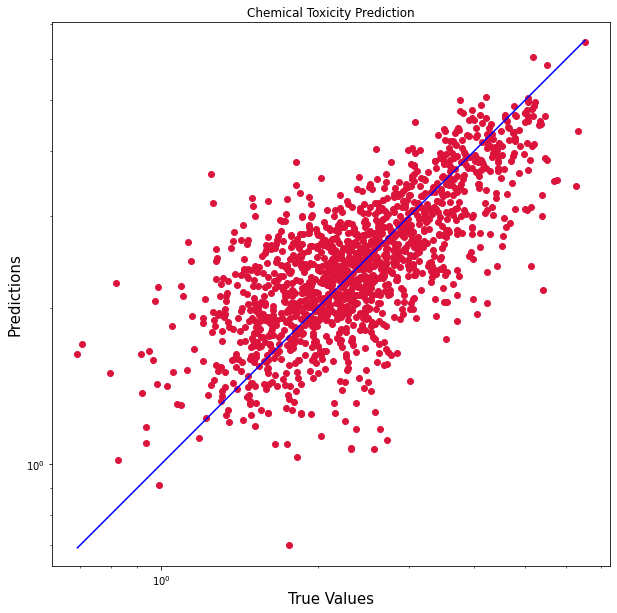

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_label, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_label))
p2 = min(min(y_pred), min(y_label))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Chemical Toxicity Prediction')
plt.show()